In [1]:
import sys
sys.path.insert(0,'../backend')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gym
import stable_baselines
from stable_baselines import A2C, ACER, ACKTR, DQN, DDPG, SAC, PPO1, PPO2, TD3, TRPO
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.gail import ExpertDataset, generate_expert_traj

import webotsgym as wg

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
config = wg.WbtConfig()
config.world_size = 3
config.num_obstacles = 0
config.sim_mode = wg.config.SimSpeedMode.RUN
config.sim_step_every_x = 5
config.relative_action = True
config.direction_type = wg.config.DirectionType.STEERING

In [4]:
def predict(env, seed, model, steps=100, render=False):    
    obs = env.reset(seed)
    for i in range(steps):
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)

        if env.get_target_distance() < 0.08:
            return i
        
    return steps+20

In [5]:
# model loading
model_name = "3x3_reach_target_v6"
model1 = PPO1.load("model/continuous/{}".format(model_name))
# model2 = PPO1.load("models/keep/comparison_timesteps/{}".format("PPO_160k_4sensors_N=10_seed=1_obs=3x1"))
models = [model1]
names = ["3x3"]


env = wg.WbtGym(train=True, 
                config=config)
env.com.send_data_request()
env.get_data()
obs = env.observation
res_all = np.empty((0, len(models)))

num_of_steps = 500
num_of_envs = 5

for env_seed in range(num_of_envs):
    res_env = np.empty(len(models))
    for model in models:
        res_env[models.index(model)] = predict(env, env_seed, model, num_of_steps)
    res_all = np.vstack((res_all, res_env))
    
df = pd.DataFrame(res_all)
df.columns = names





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


../backend/webotsgym/env/webotenv.py:111: UserWarning: Relative property of action class is overwritten by config.relative_action.
  warnings.warn("Relative property of action class is overwritten "


Accepting on Port:  10201
ERROR: recv msg count, is  1  should  2


In [6]:
df_analysis = df.copy()
df_analysis["all"] = df_analysis.sum(axis=1)
df_analysis["seed"] = range(num_of_envs)
df_analysis.sort_values("all", ascending=False)

,3x3,all,seed
2,224.0,224.0,2
4,206.0,206.0,4
0,85.0,85.0,0
1,72.0,72.0,1
3,19.0,19.0,3


In [7]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

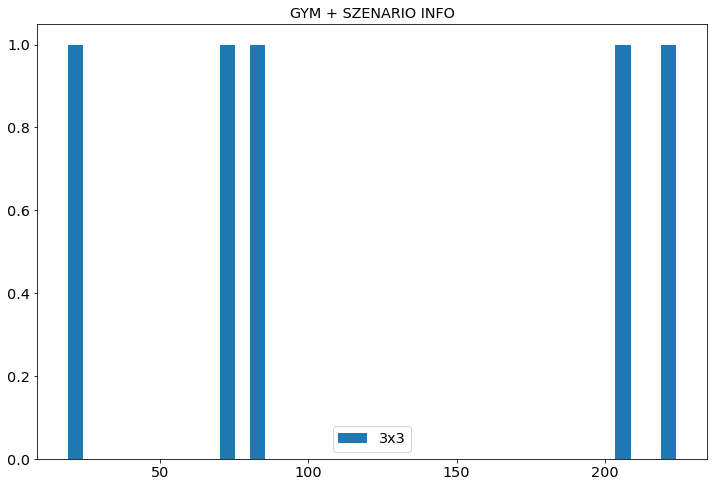

In [8]:
plt.figure(figsize=(12,8))
plt.hist(df.values, 40, histtype='bar', label=names)
plt.title('GYM + SZENARIO INFO')
plt.legend()
plt.show()